# A/B Testing Project - from an international online store

**Task**

You've received an analytical task from an international online store. Your predecessor failed to complete it: they launched an A/B test and then quit (to start a watermelon farm in Brazil). They left only the technical specifications and the test results.


**Technical description**

- Test name: `recommender_system_test`
- Groups: А (control), B (new payment funnel)
- Launch date: 2020-12-07
- The date when they stopped taking up new users: 2020-12-21
- End date: 2021-01-01
- Audience: 15% of the new users from the EU region
- Purpose of the test: testing changes related to the introduction of an improved recommendation system
- Expected result: within 14 days of signing up, users will show better conversion into product page views (the `product_page` event), product card views (`product_card`) and purchases (`purchase`). At each of the stage of the funnel `product_page → product_card → purchase`, there will be at least a 10% increase.
- Expected number of test participants: 6000

Download the test data, see whether it was carried out correctly, and analyze the results.

# Description of the data

To access the datasets on the platform, add /datasets/ to the beginning of the file path (for instance, /datasets/ab_project_marketing_events_us.csv).


- `ab_project_marketing_events_us.csv` — the calendar of marketing events for 2020
- `final_ab_new_users_upd_us.csv` — all users who signed up in the online store from December 7 to 21, 2020
- `final_ab_events_upd_us.csv` — all events of the new users within the period from December 7, 2020 to January 1, 2021
- `final_ab_participants_upd_us.csv` — table containing test participants


Structure of `ab_project_marketing_events_us.csv`:

- `name` — the name of the marketing event
- `regions` — regions where the ad campaign will be held
- `start_dt` — campaign start date
- `finish_dt` — campaign end date

Structure of `final_ab_new_users_upd_us.csv`:

- `user_id`
- `first_date` — sign-up date
- `region`
- `device` — device used to sign up

Structure of `final_ab_events_upd_us.csv`:

- `user_id`
- `event_dt` — event date and time
- `event_name` — event type name
- `details` — additional data on the event (for instance, the order total in USD for `purchase` events)

Structure of `final_ab_participants_upd_us.csv`:

- `user_id`
- `ab_test` — test name
- `group` — the test group the user belonged to

# Instructions on completing the task

- Describe the goals of the research
- Explore the data
    - Does it need converting types?
    - Are there any missing or duplicate values? If so, what's their nature?
- Carry out exploratory data analysis
    - Study conversion at different funnel stages
    - Is the number of events per user distributed equally in the samples?
    - Are there users who enter both samples?
    - How is the number of events distributed by days?
    - Think of the possible details in the data that you have to take into account before starting the A/B test?
- Evaluate the A/B test results
    - What can you tell about the A/B test results?
    - Use the z-criterion to check the statistical difference between the proportions
- Describe the conclusions on the EDA stage, as well as on the evaluation of the A/B test results

# Goals of the Research

# Step 1. Download the data and prepare it for analysis

In [435]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from datetime import timedelta
import plotly.express as px
import plotly.graph_objects as go
import scipy.stats as stats
import datetime as dt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from scipy import stats as st
import math as mth
# from pandas.tseries.offsets import DateOffset

import warnings
warnings.filterwarnings('ignore')

In [436]:
try:
    marketing = pd.read_csv('ab_project_marketing_events_us.csv')
    new_users = pd.read_csv('final_ab_new_users_upd_us.csv')
    events = pd.read_csv('final_ab_events_upd_us.csv')
    participants = pd.read_csv('final_ab_participants_upd_us.csv')
except:    
    marketing = pd.read_csv('/datasets/ab_project_marketing_events_us.csv')
    new_users = pd.read_csv('/datasets/final_ab_new_users_upd_us.csv')
    events = pd.read_csv('/datasets/final_ab_events_upd_us.csv')
    participants = pd.read_csv('/datasets/final_ab_participants_upd_us.csv')
finally:
    print('Try to read files')
       
marketing.head()

Try to read files


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


In [437]:
# To know the number of columns and rows in the DataFrame
marketing.shape

(14, 4)

In [438]:
# To check whether column's name are written in appropriate way
marketing.columns

Index(['name', 'regions', 'start_dt', 'finish_dt'], dtype='object')

In [439]:
# Get information about the DataFrame
marketing.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 4.0 KB


In [440]:
# Check data type of the DataFrame
marketing.dtypes

name         object
regions      object
start_dt     object
finish_dt    object
dtype: object

In [441]:
# Checking duplicates in the DataFrame
marketing.duplicated().sum()

0

In [442]:
# To confirm the missing values of the DataFrame
marketing.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [443]:
# To get the percentile information of the columns in the dataframe
marketing.isnull().sum()*100/len(marketing)

name         0.0
regions      0.0
start_dt     0.0
finish_dt    0.0
dtype: float64

In [444]:
# To get information about statistical character of the DataFrame
marketing.describe()

,name,regions,start_dt,finish_dt
count,14,14,14,14
unique,14,6,14,14
top,Christmas&New Year Promo,APAC,2020-10-01,2020-07-11
freq,1,4,1,1


In [445]:
# Print a sample of DataFrame for gamess
marketing.head(10)

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [446]:
# To check if there are unique values
marketing['name'].unique()

array(['Christmas&New Year Promo', "St. Valentine's Day Giveaway",
       "St. Patric's Day Promo", 'Easter Promo', '4th of July Promo',
       'Black Friday Ads Campaign', 'Chinese New Year Promo',
       'Labor day (May 1st) Ads Campaign',
       "International Women's Day Promo",
       'Victory Day CIS (May 9th) Event', 'CIS New Year Gift Lottery',
       'Dragon Boat Festival Giveaway', "Single's Day Gift Promo",
       'Chinese Moon Festival'], dtype=object)

In [447]:
# To check if there are unique values
marketing['regions'].unique()

array(['EU, N.America', 'EU, CIS, APAC, N.America', 'N.America', 'APAC',
       'EU, CIS, APAC', 'CIS'], dtype=object)

In [448]:
# To check if there are unique values
marketing['start_dt'].unique()

array(['2020-12-25', '2020-02-14', '2020-03-17', '2020-04-12',
       '2020-07-04', '2020-11-26', '2020-01-25', '2020-05-01',
       '2020-03-08', '2020-05-09', '2020-12-30', '2020-06-25',
       '2020-11-11', '2020-10-01'], dtype=object)

In [449]:
# To check if there are unique values
marketing['finish_dt'].unique()

array(['2021-01-03', '2020-02-16', '2020-03-19', '2020-04-19',
       '2020-07-11', '2020-12-01', '2020-02-07', '2020-05-03',
       '2020-03-10', '2020-05-11', '2021-01-07', '2020-07-01',
       '2020-11-12', '2020-10-07'], dtype=object)

In [450]:
# To know the number of columns and rows in the DataFrame
new_users.shape

(58703, 4)

In [451]:
# To check whether column's name are written in appropriate way
new_users.columns

Index(['user_id', 'first_date', 'region', 'device'], dtype='object')

In [452]:
# Get information about the DataFrame
new_users.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     58703 non-null  object
 1   first_date  58703 non-null  object
 2   region      58703 non-null  object
 3   device      58703 non-null  object
dtypes: object(4)
memory usage: 14.7 MB


In [453]:
# Check data type of the DataFrame
new_users.dtypes

user_id       object
first_date    object
region        object
device        object
dtype: object

In [454]:
# Checking duplicates in the DataFrame
new_users.duplicated().sum()

0

In [455]:
# To confirm the missing values of the DataFrame
new_users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [456]:
# To get the percentile information of the columns in the dataframe
new_users.isnull().sum()*100/len(new_users)

user_id       0.0
first_date    0.0
region        0.0
device        0.0
dtype: float64

In [457]:
# To get information about statistical character of the DataFrame
new_users.describe()

,user_id,first_date,region,device
count,58703,58703,58703,58703
unique,58703,17,4,4
top,BD6F2A2AF61177E2,2020-12-21,EU,Android
freq,1,6077,43396,26159


In [458]:
# Print a sample of DataFrame for gamess
new_users.head(10)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
5,137119F5A9E69421,2020-12-07,N.America,iPhone
6,62F0C741CC42D0CC,2020-12-07,APAC,iPhone
7,8942E64218C9A1ED,2020-12-07,EU,PC
8,499AFACF904BBAE3,2020-12-07,N.America,iPhone
9,FFCEA1179C253104,2020-12-07,EU,Android


In [459]:
# To check if there are unique values
new_users['user_id'].unique()

array(['D72A72121175D8BE', 'F1C668619DFE6E65', '2E1BF1D4C37EA01F', ...,
       '7ADEE837D5D8CBBD', '1C7D23927835213F', '8F04273BB2860229'],
      dtype=object)

In [460]:
# To check if there are unique values
new_users['first_date'].unique()

array(['2020-12-07', '2020-12-14', '2020-12-21', '2020-12-08',
       '2020-12-15', '2020-12-22', '2020-12-09', '2020-12-16',
       '2020-12-23', '2020-12-10', '2020-12-17', '2020-12-11',
       '2020-12-18', '2020-12-12', '2020-12-19', '2020-12-13',
       '2020-12-20'], dtype=object)

In [461]:
# To check if there are unique values
new_users['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

In [462]:
# To check if there are unique values
new_users['device'].unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

In [463]:
# To know the number of columns and rows in the DataFrame
events.shape

(423761, 4)

In [464]:
# To check whether column's name are written in appropriate way
events.columns

Index(['user_id', 'event_dt', 'event_name', 'details'], dtype='object')

In [465]:
# Get information about the DataFrame
events.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     423761 non-null  object 
 1   event_dt    423761 non-null  object 
 2   event_name  423761 non-null  object 
 3   details     60314 non-null   float64
dtypes: float64(1), object(3)
memory usage: 89.9 MB


In [466]:
# Check data type of the DataFrame
events.dtypes

user_id        object
event_dt       object
event_name     object
details       float64
dtype: object

In [467]:
# Checking duplicates in the DataFrame
events.duplicated().sum()

0

In [468]:
# To confirm the missing values of the DataFrame
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

In [469]:
# To get the percentile information of the columns in the dataframe
events.isnull().sum()*100/len(events)

user_id        0.000000
event_dt       0.000000
event_name     0.000000
details       85.766977
dtype: float64

In [470]:
# To get information about statistical character of the DataFrame
events.describe()

,details
count,60314.000000
mean,23.881219
std,72.228884
min,4.990000
25%,4.990000
50%,4.990000
75%,9.990000
max,499.990000


In [471]:
# Print a sample of DataFrame for gamess
events.head(10)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99
6,6B2F726BFD5F8220,2020-12-07 11:27:42,purchase,4.99
7,BEB37715AACF53B0,2020-12-07 04:26:15,purchase,4.99
8,B5FA27F582227197,2020-12-07 01:46:37,purchase,4.99
9,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.99


In [472]:
# To check if there are unique values
events['user_id'].unique()

array(['E1BDDCE0DAFA2679', '7B6452F081F49504', '9CD9F34546DF254C', ...,
       'C9F1399FDCD83F13', '4F32B58E4FF19DC5', '27767D4BECDD260E'],
      dtype=object)

In [473]:
# To check if there are unique values
events['event_dt'].unique()

array(['2020-12-07 20:22:03', '2020-12-07 09:22:53',
       '2020-12-07 12:59:29', ..., '2020-12-30 12:21:24',
       '2020-12-30 10:54:15', '2020-12-30 10:59:09'], dtype=object)

In [474]:
# To check if there are unique values
events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [475]:
# To check if there are unique values
events['details'].unique()

array([ 99.99,   9.99,   4.99, 499.99,    nan])

In [476]:
# To know the number of columns and rows in the DataFrame
participants.shape

(14525, 3)

In [477]:
# Get information about the DataFrame
participants.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 2.9 MB


In [478]:
# Check data type of the DataFrame
participants.dtypes

user_id    object
group      object
ab_test    object
dtype: object

In [479]:
# Checking duplicates in the DataFrame
participants.duplicated().sum()

0

In [480]:
# To confirm the missing values of the DataFrame
participants.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

In [481]:
# To get the percentile information of the columns in the dataframe
participants.isnull().sum()*100/len(participants)

user_id    0.0
group      0.0
ab_test    0.0
dtype: float64

In [482]:
# To get information about statistical character of the DataFrame
participants.describe()

,user_id,group,ab_test
count,14525,14525,14525
unique,13638,2,2
top,123C3AC236BE84F0,A,interface_eu_test
freq,2,8214,10850


In [483]:
# Print a sample of DataFrame for gamess
participants.head(10)

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,4FF2998A348C484F,A,recommender_system_test
5,7473E0943673C09E,A,recommender_system_test
6,C46FE336D240A054,A,recommender_system_test
7,92CB588012C10D3D,A,recommender_system_test
8,B3A2485649E4A012,A,recommender_system_test
9,66FC298441D50783,A,recommender_system_test


In [484]:
# To check if there are unique values
participants['user_id'].unique()

array(['D1ABA3E2887B6A73', 'A7A3664BD6242119', 'DABC14FDDFADD29E', ...,
       'F501F79D332BE86C', '63FBE257B05F2245', '79F9ABFB029CF724'],
      dtype=object)

In [485]:
# To check if there are unique values
participants['group'].unique()

array(['A', 'B'], dtype=object)

In [486]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
dtypes: object(3)
memory usage: 340.6+ KB


In [487]:
# To check if there are unique values
participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

**Conclusion**


   * There are four DataFrames;namely, marketing, new_users, events and participants.
   * The marketing DataFrame has 14 rows and 4 columns. It has all object data types.
   * It has been confirmed that the marketing DataFrames has no duplicates and missing values.
   * Some type types of the marketing DataFrame needs to be converted into the right data type.
   * The new_users DataFrame has 58703 rows and 4 columns. It has all object data types.
   * It has been confirmed that the new_users DataFrames has no duplicates and missing values.
   * Some type types of the new_users DataFrame needs to be converted into the right data type.
   * The events DataFrame has 423761 rows and 4 columns. It has object and float 64 data types.
   * It has been confirmed that the events DataFrames has no duplicates and but it has missing values.
   * The events DataFrame has 363447 missing values in the 'details' column which is more than 85%.
   * Some type types of the events DataFrame needs to be converted into the right data type.
   * The participants DataFrame has 14525 rows and 3 columns. It has all object data type.
   * It has been confirmed that the participants DataFrames has no duplicates and missing values.
   * The data is for two AB test and users may have different sources and regions.


# Step 2. Data Preprocessing

**Converting data types**

In [488]:
# To convert data type from object into datetime
marketing['start_dt'] = pd.to_datetime(marketing['start_dt'], format="%Y-%m-%d")

In [489]:
# To convert data type from object into datetime
marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt'], format="%Y-%m-%d")

In [490]:
# To confirm if the data type is converted
marketing.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 2.4 KB


In [491]:
# To convert data type from object into datetime
new_users['first_date'] = pd.to_datetime(new_users['first_date'], format="%Y-%m-%d")

In [492]:
# Change the type of `region` column to category
new_users['region'] = new_users['region'].astype('category')

In [493]:
# Change the type of `device` column to category
new_users['device'] = new_users['device'].astype('category')

In [494]:
# To confirm if the data type is converted
new_users.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  category      
 3   device      58703 non-null  category      
dtypes: category(2), datetime64[ns](1), object(1)
memory usage: 4.6 MB


In [495]:
# Checking the Data Frame
events.tail(5)

,user_id,event_dt,event_name,details
423756,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
423757,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
423758,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
423759,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN
423760,7AEC61159B672CC5,2020-12-30 11:36:13,login,NaN


In [496]:
# To convert data type from object into datetime
events['event_dt'] = pd.to_datetime(events['event_dt'], format="%Y-%m-%d %H:%M:%S")

In [497]:
# Change the type of `event_name` column to category
events['event_name'] = events['event_name'].astype('category')

In [498]:
# To confirm if the data type is converted
events.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423761 entries, 0 to 423760
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     423761 non-null  object        
 1   event_dt    423761 non-null  datetime64[ns]
 2   event_name  423761 non-null  category      
 3   details     60314 non-null   float64       
dtypes: category(1), datetime64[ns](1), float64(1), object(1)
memory usage: 36.4 MB


In [499]:
# Change the type of `group` column to category
participants['group'] = participants['group'].astype('category')

In [500]:
# Change the type of `ab_test` column to category
participants['ab_test'] = participants['ab_test'].astype('category')

In [501]:
# To confirm if the data type is converted
participants.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   user_id  14525 non-null  object  
 1   group    14525 non-null  category
 2   ab_test  14525 non-null  category
dtypes: category(2), object(1)
memory usage: 1.0 MB


In [502]:
# To confirm the missing values of the DataFrame
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       363447
dtype: int64

In [503]:
# To get the percentile information of the columns in the dataframe
events.isnull().sum()*100/len(events)

user_id        0.000000
event_dt       0.000000
event_name     0.000000
details       85.766977
dtype: float64

The column 'details' has 85.77% missing values. I don't want to drop them as they can affect the other informations instead I prefered to fill them with zero value.

There are missing values in the one column of the DataFrame events i.e 'event_name'. Here it explains only 62740 users purchased where as 363447 users did not purchase, that is why they don't have detailed information about them. I prefered to use Arbitrary value imputation technique. Arbitrary value imputation consists of replacing all occurrences of missing values within a variable with an arbitrary value.  Therefore, I decided to fill them with zero value as they don't affect the test (they are irrevevant to the test).

In [504]:
# filling missing values with 0
events['details'] = events['details'].fillna(0)

In [505]:
# To confirm if the missing values of the DataFrame are fixed
events.isna().sum()

user_id       0
event_dt      0
event_name    0
details       0
dtype: int64

In [506]:
# To get information about statistical character of the DataFrame
events.describe()

,details
count,423761.000000
mean,3.399019
std,28.498201
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,499.990000


In [507]:
# Print a sample of DataFrame for gamess
events.sample(10)

,user_id,event_dt,event_name,details
267504,7BE54404925DA3BB,2020-12-11 14:03:58,login,0.0
298636,45B9BCD9882F70AE,2020-12-15 06:30:19,login,0.0
383081,FE08A72BE2C8C7EB,2020-12-22 06:40:42,login,0.0
90772,91BD4F4ED4695877,2020-12-18 07:16:10,product_cart,0.0
93896,FD7CAE981D045169,2020-12-19 14:08:29,product_cart,0.0
77855,3168D9D825BD0B04,2020-12-14 22:11:20,product_cart,0.0
393918,BDA46D3968949272,2020-12-23 14:47:16,login,0.0
397996,089E70B4BCA16B53,2020-12-24 21:28:23,login,0.0
371350,0CF2207D5F76F678,2020-12-22 06:33:52,login,0.0
93176,D48688BB18105CE4,2020-12-19 06:01:50,product_cart,0.0


In [508]:
# Informatation about the launching date Data Frame
new_users.head(5)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [509]:
# Informatation about the end date Data Frame
new_users.tail(5)

,user_id,first_date,region,device
58698,1DB53B933257165D,2020-12-20,EU,Android
58699,538643EB4527ED03,2020-12-20,EU,Mac
58700,7ADEE837D5D8CBBD,2020-12-20,EU,PC
58701,1C7D23927835213F,2020-12-20,EU,iPhone
58702,8F04273BB2860229,2020-12-20,EU,Android


In [510]:
new_users.describe()

,user_id,first_date,region,device
count,58703,58703,58703,58703
unique,58703,17,4,4
top,BD6F2A2AF61177E2,2020-12-21 00:00:00,EU,Android
freq,1,6077,43396,26159
first,NaN,2020-12-07 00:00:00,NaN,NaN
last,NaN,2020-12-23 00:00:00,NaN,NaN


In [511]:
# To check the exact launching date
data_min = new_users['first_date'].min()
print('The minimum date is:', data_min)

The minimum date is: 2020-12-07 00:00:00


In [512]:
# To check the exact end date
data_max = new_users['first_date'].max()
print('The maximum date is:', data_max)

The maximum date is: 2020-12-23 00:00:00


In [513]:
new_users.query('first_date <= "2020-12-21"').count()

user_id       53440
first_date    53440
region        53440
device        53440
dtype: int64

In [514]:
new_users.query('first_date > "2020-12-21"').count()

user_id       5263
first_date    5263
region        5263
device        5263
dtype: int64

In [515]:
new_users.query('first_date == "2020-12-23"').count()

user_id       2180
first_date    2180
region        2180
device        2180
dtype: int64

Based on the result the last date registration for the new user was 12-23-2020 not 12-21-2020.

In [516]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [517]:
# To check the exact launching date
data_min = events['event_dt'].min()
print('The minimum date is:', data_min)

The minimum date is: 2020-12-07 00:00:33


In [518]:
# To check the exact end date
data_max = events['event_dt'].max()
print('The maximum date is:', data_max)

The maximum date is: 2020-12-30 23:36:33


In [519]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58703 entries, 0 to 58702
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     58703 non-null  object        
 1   first_date  58703 non-null  datetime64[ns]
 2   region      58703 non-null  category      
 3   device      58703 non-null  category      
dtypes: category(2), datetime64[ns](1), object(1)
memory usage: 1.0+ MB


In [520]:
# To get unique values of tjhe Data Frame
new_users['region'].unique()

['EU', 'N.America', 'APAC', 'CIS']
Categories (4, object): ['EU', 'N.America', 'APAC', 'CIS']

In [521]:
# To get the distribution of users in the region
region_values = new_users['region'].value_counts()
region_values

EU           43396
N.America     9051
CIS           3130
APAC          3126
Name: region, dtype: int64

In [522]:
region_values['EU'] * 0.15

6509.4

* There are four regions; namely, EU, N.America, CIS and APAC.
* The 15% of the EU value is 6509.4 which is greater than 6000.

**Conclusion**

* The first sign up for new users was 2020-12-07.
* Based on the result the last date registration for the new user was 2020-12-23 not 2020-12-21.
* The first event was 2020-12-07.
* The last event was 2020-12-30.
* The number of new users registered on 2020-12-21 and earlier are 53440.
* The number of new users registered beyond 2020-12-21 are 5263.

# Step 3. Data Analysis

In [523]:
new_users_filter = new_users.query('region == "EU"')

new_users_filter.head(5)

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
7,8942E64218C9A1ED,2020-12-07,EU,PC
9,FFCEA1179C253104,2020-12-07,EU,Android


In [524]:
events_users = pd.merge(left = events, right = new_users_filter, how ='outer', on=['user_id'])
events_users.head()

,user_id,event_dt,event_name,details,first_date,region,device
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,NaT,NaN,NaN
1,E1BDDCE0DAFA2679,2020-12-09 06:21:35,purchase,9.99,NaT,NaN,NaN
2,E1BDDCE0DAFA2679,2020-12-07 20:22:03,login,0.00,NaT,NaN,NaN
3,E1BDDCE0DAFA2679,2020-12-09 06:21:35,login,0.00,NaT,NaN,NaN
4,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,EU,iPhone


In [525]:
data = pd.merge(left = events_users, right = participants, how ='outer', on=['user_id'])
data.sample(10)

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
105767,E0DAA5D799A51687,2020-12-18 09:30:13,login,0.0,2020-12-15,EU,Android,NaN,NaN
350727,FE6EF407258F7FCE,2020-12-20 23:29:05,login,0.0,NaT,NaN,NaN,NaN,NaN
303058,8B3FA4F42BA3DEA5,2020-12-07 13:33:51,login,0.0,2020-12-07,EU,Android,A,interface_eu_test
336539,EF3F2F9EFBA269EF,2020-12-14 04:26:50,login,0.0,NaT,NaN,NaN,NaN,NaN
265096,ACE23043749E2654,2020-12-26 05:21:48,login,0.0,NaT,NaN,NaN,NaN,NaN
123026,2643B8B9ABC130CE,2020-12-24 23:29:49,product_page,0.0,NaT,NaN,NaN,NaN,NaN
315588,A0E6B968C70ED94A,2020-12-10 03:38:17,product_page,0.0,NaT,NaN,NaN,NaN,NaN
245070,BA210531E92EF905,2020-12-29 00:10:51,product_page,0.0,NaT,NaN,NaN,NaN,NaN
295464,B4D33A4F91B9D6A0,2020-12-15 16:04:45,login,0.0,2020-12-07,EU,Android,NaN,NaN
292791,834664350CF507C5,2020-12-08 23:56:49,product_page,0.0,2020-12-07,EU,Android,A,interface_eu_test


In [526]:
data['ab_test'].value_counts()

interface_eu_test          78929
recommender_system_test    23909
Name: ab_test, dtype: int64

In [527]:
data_filtered_interface = data.query('ab_test == "interface_eu_test"')
data_filtered_interface.head(5)

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
24,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,EU,iPhone,B,interface_eu_test
25,96F27A054B191457,2020-12-08 09:43:14,purchase,4.99,2020-12-07,EU,iPhone,B,interface_eu_test
26,96F27A054B191457,2020-12-09 00:44:10,purchase,4.99,2020-12-07,EU,iPhone,B,interface_eu_test
27,96F27A054B191457,2020-12-26 00:33:57,purchase,9.99,2020-12-07,EU,iPhone,B,interface_eu_test
28,96F27A054B191457,2020-12-07 04:02:41,product_page,0.00,2020-12-07,EU,iPhone,B,interface_eu_test


In [528]:
data_filtered_recommender = data.query('ab_test == "recommender_system_test"')
data_filtered_recommender.head(5)

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
42,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,EU,Android,A,recommender_system_test
43,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,2020-12-07,EU,Android,A,recommender_system_test
44,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,0.00,2020-12-07,EU,Android,A,recommender_system_test
45,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,0.00,2020-12-07,EU,Android,A,recommender_system_test
46,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,0.00,2020-12-07,EU,Android,A,recommender_system_test


In [529]:
data.head(5)

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,NaT,NaN,NaN,NaN,NaN
1,E1BDDCE0DAFA2679,2020-12-09 06:21:35,purchase,9.99,NaT,NaN,NaN,NaN,NaN
2,E1BDDCE0DAFA2679,2020-12-07 20:22:03,login,0.00,NaT,NaN,NaN,NaN,NaN
3,E1BDDCE0DAFA2679,2020-12-09 06:21:35,login,0.00,NaT,NaN,NaN,NaN,NaN
4,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,EU,iPhone,NaN,NaN


In [530]:
data['user_id'].duplicated().sum()

370773

In [531]:
data.drop_duplicates().reset_index(drop = True).head(5)

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,NaT,NaN,NaN,NaN,NaN
1,E1BDDCE0DAFA2679,2020-12-09 06:21:35,purchase,9.99,NaT,NaN,NaN,NaN,NaN
2,E1BDDCE0DAFA2679,2020-12-07 20:22:03,login,0.00,NaT,NaN,NaN,NaN,NaN
3,E1BDDCE0DAFA2679,2020-12-09 06:21:35,login,0.00,NaT,NaN,NaN,NaN,NaN
4,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,EU,iPhone,NaN,NaN


In [532]:
# Dropping the duplicates
data_interface = data_filtered_interface.dropna()

In [533]:
# Dropping the duplicates
data_recommender = data_filtered_recommender.dropna()

In [534]:
# Only unique values
data_interface['user_id'].nunique()

10850

In [535]:
# Only unique values
data_recommender['user_id'].nunique()

3481

* There are only 10850 unique users in the interface tests.
* There are only 3481 unique users in the recommender tests.

In [536]:
# Checking none values
data_interface.isna().sum()

user_id       0
event_dt      0
event_name    0
details       0
first_date    0
region        0
device        0
group         0
ab_test       0
dtype: int64

In [537]:
# Checking none values
data_recommender.isna().sum()

user_id       0
event_dt      0
event_name    0
details       0
first_date    0
region        0
device        0
group         0
ab_test       0
dtype: int64

In [538]:
# Cecking duplicates
data_interface.duplicated().sum()

0

In [539]:
# Cecking duplicates
data_recommender.duplicated().sum()

0

In [540]:
data_interface['ab_test'].value_counts()

interface_eu_test          78929
recommender_system_test        0
Name: ab_test, dtype: int64

In [541]:
data_recommender['ab_test'].value_counts()

recommender_system_test    22674
interface_eu_test              0
Name: ab_test, dtype: int64

In [542]:
data_interface.event_name.unique()

['purchase', 'product_page', 'login', 'product_cart']
Categories (4, object): ['purchase', 'product_page', 'login', 'product_cart']

In [543]:
data_recommender.event_name.unique()

['purchase', 'product_cart', 'login', 'product_page']
Categories (4, object): ['purchase', 'product_cart', 'login', 'product_page']

In [544]:
unique_users_interface = data_interface['user_id'].nunique()
print('The total number of unique interface users is:', unique_users_interface)

The total number of unique interface users is: 10850


In [545]:
unique_users_recommender = data_recommender['user_id'].nunique()
print('The total number of unique recommender users is:', unique_users_recommender)

The total number of unique recommender users is: 3481


In [546]:
# Funnel conversion
users_funnel_interface = data_interface.groupby('event_name').agg({'user_id':'nunique'}).sort_values('user_id', ascending=False).reset_index()
users_funnel_interface

,event_name,user_id
0,login,10849
1,product_page,7166
2,purchase,3713
3,product_cart,3568


In [547]:
# Funnel conversion
users_funnel_recommender = data_recommender.groupby('event_name').agg({'user_id':'nunique'}).sort_values('user_id', ascending=False).reset_index()
users_funnel_recommender

,event_name,user_id
0,login,3480
1,product_page,2178
2,purchase,1082
3,product_cart,1026


In [548]:
users_funnel_interface.columns = ['event_name', 'n_users']

In [549]:
users_funnel_recommender.columns = ['event_name', 'n_users']

In [550]:
users_funnel_interface['conversion (%)'] = users_funnel_interface['n_users']/unique_users_interface*100
users_funnel_interface

,event_name,n_users,conversion (%)
0,login,10849,99.990783
1,product_page,7166,66.046083
2,purchase,3713,34.221198
3,product_cart,3568,32.884793


In [551]:
users_funnel_recommender['conversion (%)'] = users_funnel_recommender['n_users']/unique_users_recommender*100
users_funnel_recommender

,event_name,n_users,conversion (%)
0,login,3480,99.971273
1,product_page,2178,62.568228
2,purchase,1082,31.083022
3,product_cart,1026,29.474289


In [552]:
users_funnel_recommender.set_index(pd.Index([0, 1, 3, 2]), inplace=True)
users_funnel_recommender.sort_index(inplace=True)
users_funnel_recommender

,event_name,n_users,conversion (%)
0,login,3480,99.971273
1,product_page,2178,62.568228
2,product_cart,1026,29.474289
3,purchase,1082,31.083022


In [553]:
funnel_by_groups_interface=[]
for i in data_interface.group.unique():
    groups = data_interface[data_interface.group==i].groupby(['event_name', 'group'])['user_id'].nunique().reset_index()\
    .sort_values(by='user_id', ascending=False)
    funnel_by_groups_interface.append(groups)    


In [554]:
funnel_by_groups_interface = pd.concat(funnel_by_groups_interface)

In [555]:
funnel_by_groups_recommender=[]
for i in data_recommender.group.unique():
    groups = data_recommender[data_recommender.group==i].groupby(['event_name', 'group'])['user_id'].\
    nunique().reset_index()\
    .sort_values(by='user_id', ascending=False)
    funnel_by_groups_recommender.append(groups)   

In [556]:
funnel_by_groups_recommender = pd.concat(funnel_by_groups_recommender)

In [557]:
# Events funnel at each stage
funnel_interface = px.funnel(funnel_by_groups_interface, x = 'user_id', y = 'event_name', title = 'Event Funnel of Interface Test at Each Stage', color= 'group')
funnel_interface.update_layout(
    margin = dict(t = 25, l = 6, b = 6, r = 8))
funnel_interface.show()

In [558]:
# Events funnel at each stage
funnel_recommender = px.funnel(funnel_by_groups_recommender, x = 'user_id', y = 'event_name', title = 'Event Funnel of Interface Test at Each Stage', color= 'group')
funnel_recommender.update_layout(
    margin = dict(t = 25, l = 6, b = 6, r = 8))
funnel_recommender.show()

In [559]:
# Events funnel at each stage
funnel_recommender = px.funnel(funnel_by_groups_recommender, x = 'user_id', y = 'event_name',
                               title = 'Event Funnel of Recommender Test at Each Stage', color= 'group')
funnel_recommender.update_layout(
    margin = dict(t = 15, l = 4, b = 4, r = 4))
funnel_recommender.show()

In [560]:
# the reviewer's code:
funnel_recommender = px.funnel(funnel_by_groups_recommender.query('user_id != 0'), x = 'user_id', y = 'event_name',
                               title = 'Event Funnel of Recommender Test at Each Stage', color= 'group')
funnel_recommender.update_layout(
    margin = dict(t = 50, l = 4, b = 4, r = 4))
funnel_recommender.show()

In [561]:
# the reviewer's code:
funnel_recommender = px.funnel(funnel_by_groups_recommender.query('user_id != 0').reindex([0,4,2,6,1,5,3,7]), 
                               x = 'user_id', y = 'event_name',
                               title = 'Event Funnel of Recommender Test at Each Stage', color= 'group')
funnel_recommender.update_layout(
    margin = dict(t = 50, l = 4, b = 4, r = 4))
funnel_recommender.show()

In [562]:
# the reviewer's cell:
display(funnel_by_groups_recommender.query('user_id != 0'))
funnel_by_groups_recommender.query('user_id != 0').index

,event_name,group,user_id
0,login,A,2604
4,product_page,A,1685
6,purchase,A,833
2,product_cart,A,782
1,login,B,876
5,product_page,B,493
7,purchase,B,249
3,product_cart,B,244


Int64Index([0, 4, 6, 2, 1, 5, 7, 3], dtype='int64')

**Is the number of events per user distributed equally in the samples?**

In [563]:
users_by_group = data_interface.groupby('group').agg({'user_id': 'nunique'})
users_by_group

,user_id
group,
A,5467
B,5383


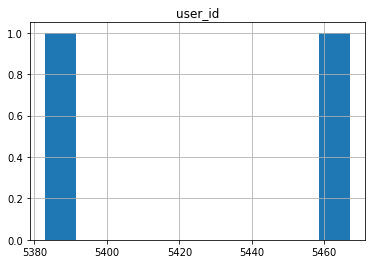

In [564]:
users_by_group.hist()
plt.show()

The result shows almost users are equally distributed in group 'A' and group 'B'.

**Are there users who enter both samples?**

In [565]:
unique_users= data_interface['user_id'].nunique()
print('The total number of unique users is:', unique_users)

The total number of unique users is: 10850


In [566]:
users_grouped = data_interface.groupby('user_id').agg({'group': 'nunique'})
users_grouped['group'].value_counts()

1    10850
Name: group, dtype: int64

Based on the result it is confirmed there are no users in both samples brcause the unique sampless as well as the group samples are the same.

In [567]:
events_per_user_interface = data_interface.groupby(['user_id','group']).agg({'event_name': 'count'}).reset_index()
events_per_user_interface = events_per_user_interface.rename(columns={'event_name' : 'event_count'})
events_per_user_interface.head()


,user_id,group,event_count
0,0002CE61FF2C4011,A,12
1,0002CE61FF2C4011,B,0
2,001064FEAAB631A1,A,0
3,001064FEAAB631A1,B,6
4,001E72F50D1C48FA,A,0


In [568]:
events_per_user_interfaceA = events_per_user_interface[events_per_user_interface['group']=='A']
events_per_user_interfaceB = events_per_user_interface[events_per_user_interface['group']=='B']

In [569]:
events_per_user_interfaceA.head(5)

,user_id,group,event_count
0,0002CE61FF2C4011,A,12
2,001064FEAAB631A1,A,0
4,001E72F50D1C48FA,A,0
6,002412F1EB3F6E38,A,6
8,002540BE89C930FB,A,9


In [570]:
events_per_user_interfaceB.tail(5)

,user_id,group,event_count
21691,FFE600EEC4BA7685,B,0
21693,FFE7FC140521F5F6,B,16
21695,FFEFC0E55C1CCD4F,B,4
21697,FFF28D02B1EACBE1,B,0
21699,FFF58BC33966EB51,B,3


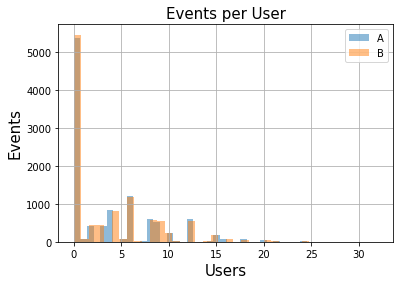

In [571]:
events_per_user_interfaceA['event_count'].hist(bins=40, alpha=0.5, label='A')
events_per_user_interfaceB['event_count'].hist(bins=40,alpha=0.5, label='B');
plt.title("Events per User", fontdict={'size':15})
plt.xlabel('Users', fontdict={'size':15})
plt.ylabel("Events",fontdict={'size':15})
plt.xticks(rotation = 0)
plt.legend();


Based on the result, it can said that the distribution of events and users in Group A and B is very similar for interface test.

In [572]:
events_per_user_recommender = data_recommender.groupby(['user_id','group']).agg({'event_name': 'count'}).reset_index()
events_per_user_recommender = events_per_user_recommender.rename(columns={'event_name' : 'event_count'})
events_per_user_recommender.head()


,user_id,group,event_count
0,001064FEAAB631A1,A,0
1,001064FEAAB631A1,B,6
2,0010A1C096941592,A,12
3,0010A1C096941592,B,0
4,00341D8401F0F665,A,2


In [573]:
events_per_user_recommenderA = events_per_user_recommender[events_per_user_recommender['group']=='A']
events_per_user_recommenderB = events_per_user_recommender[events_per_user_recommender['group']=='B']

In [574]:
events_per_user_recommenderA.head(5)

,user_id,group,event_count
0,001064FEAAB631A1,A,0
2,0010A1C096941592,A,12
4,00341D8401F0F665,A,2
6,003DF44D7589BBD4,A,15
8,00505E15A9D81546,A,5


In [575]:
events_per_user_recommenderB.tail(5)

,user_id,group,event_count
6953,FF5B24BCE4387F86,B,0
6955,FF825C1D791989B5,B,0
6957,FF8CF7057415EB29,B,2
6959,FFAE9489C76F352B,B,0
6961,FFF28D02B1EACBE1,B,9


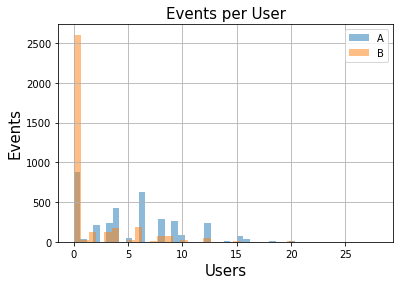

In [576]:
events_per_user_recommenderA['event_count'].hist(bins=40, alpha=0.5, label='A')
events_per_user_recommenderB['event_count'].hist(bins=40,alpha=0.5, label='B');
plt.title("Events per User", fontdict={'size':15})
plt.xlabel('Users', fontdict={'size':15})
plt.ylabel("Events",fontdict={'size':15})
plt.xticks(rotation = 0)
plt.legend();


Based on the result, it can said that the distribution of events and users in Group A and B is a little bit differ for recommender test.

In [577]:
mean_user_event_interface = round(data_interface.groupby(['user_id'])['event_name'].count().reset_index().\
                                  sort_values(by='event_name', ascending= False)['event_name'].mean(), 2)
mean_user_event_interface

7.27

In [578]:
mean_user_event_recommender = round(data_recommender.groupby(['user_id'])['event_name'].count().reset_index().\
sort_values(by='event_name', ascending= False)['event_name'].mean(), 2)
mean_user_event_recommender

6.51

The average user versus events for interfave test and recommender test are 7.27 and 6.51 respectively.

**How is the number of events distributed by days?**

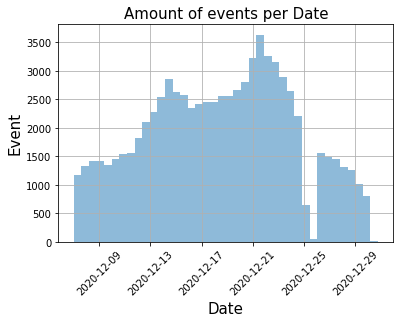

In [579]:
data_interface['event_dt'].hist(bins=40, alpha=0.5);
plt.title("Amount of events per Date", fontdict={'size':15})
plt.xlabel('Date', fontdict={'size':15})
plt.ylabel("Event",fontdict={'size':15})
plt.xticks(rotation = 45);

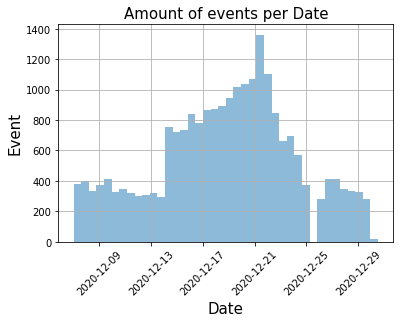

In [580]:
data_recommender['event_dt'].hist(bins=40, alpha=0.5);
plt.title("Amount of events per Date", fontdict={'size':15})
plt.xlabel('Date', fontdict={'size':15})
plt.ylabel("Event",fontdict={'size':15})
plt.xticks(rotation = 45);

* Most events happened on 12-21-2020. 
* The last new users signing up on 12-21-2020.
* Sign up starts on 12-07-2020.
* The graph looks uniform.

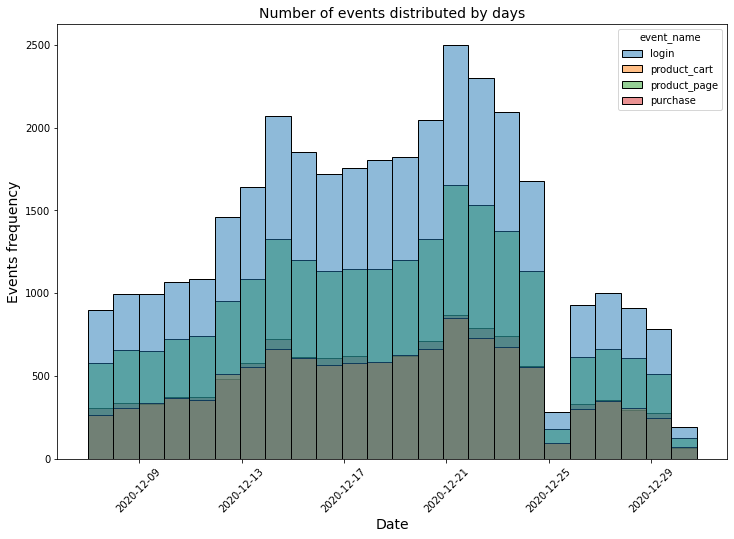

In [581]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
sns.histplot(data = data_interface, x = "event_dt", bins = 24, hue = "event_name")
ax.set_title("Number of events distributed by days", fontdict={"size":14})
plt.xlabel("Date", fontdict = {"size":14})
plt.ylabel("Events frequency", fontdict = {"size":14})
plt.xticks(rotation=45)
plt.show()

The events was increasing with respect of time until 2020-12-21 but after this day it is seen going down. This is because of sign up stopped after 14 days.

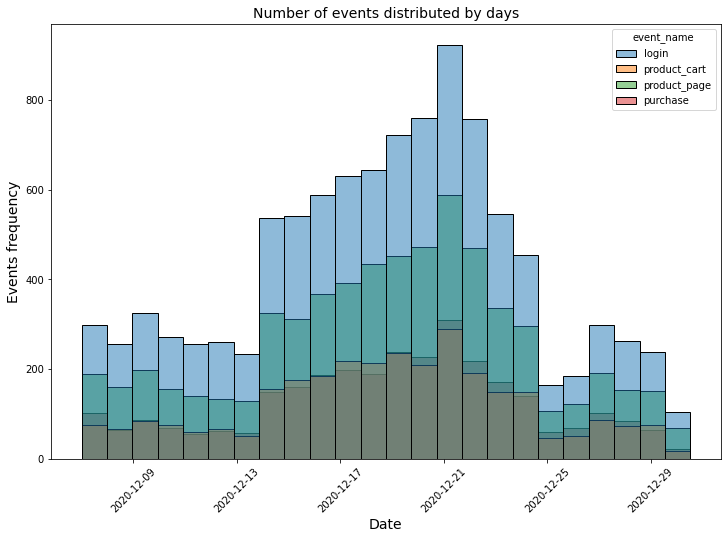

In [582]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
sns.histplot(data = data_recommender, x = "event_dt", bins = 24, hue = "event_name")
ax.set_title("Number of events distributed by days", fontdict={"size":14})
plt.xlabel("Date", fontdict = {"size":14})
plt.ylabel("Events frequency", fontdict = {"size":14})
plt.xticks(rotation=45)
plt.show()

The events was increasing with respect of time until 2020-12-21 but after this day it is seen going down. This is because of sign up stopped.

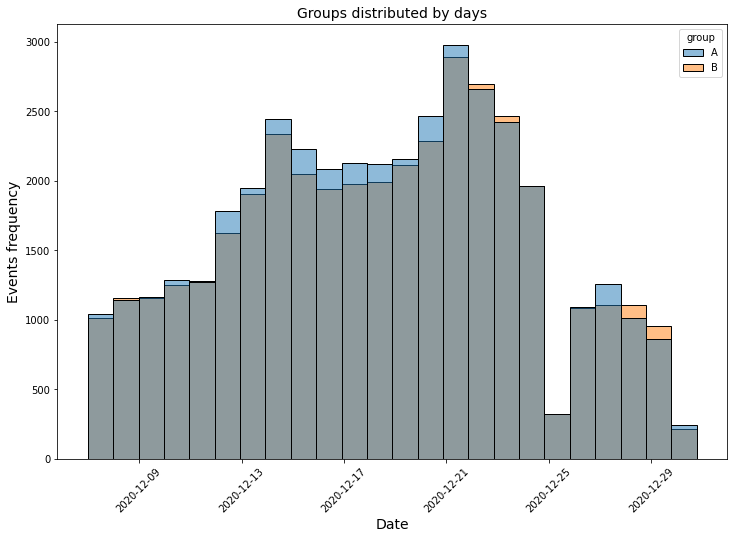

In [583]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
sns.histplot(data = data_interface, x = "event_dt", bins = 24, hue = "group")
ax.set_title("Groups distributed by days", fontdict={"size":14})
plt.xlabel("Date", fontdict = {"size":14})
plt.ylabel("Events frequency", fontdict = {"size":14})
plt.xticks(rotation=45)
plt.show()

The distribution of group A and B is similar for the interface test.

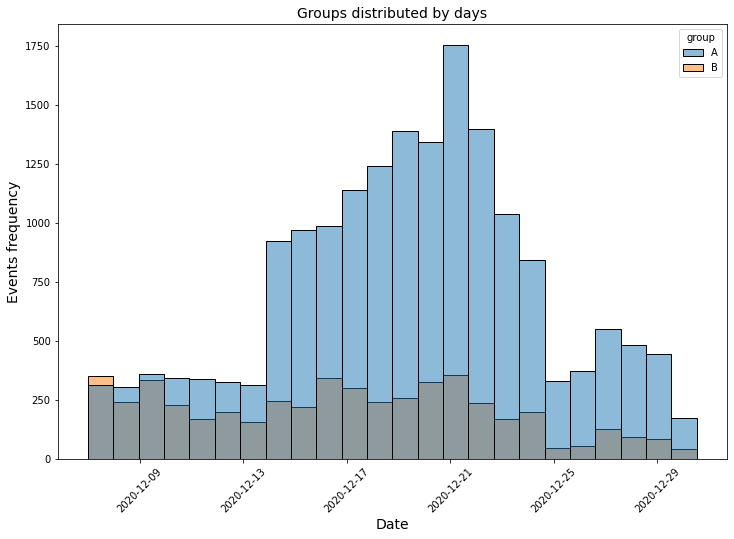

In [584]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
sns.histplot(data = data_recommender, x = "event_dt", bins = 24, hue = "group")
ax.set_title("Groups distributed by days", fontdict={"size":14})
plt.xlabel("Date", fontdict = {"size":14})
plt.ylabel("Events frequency", fontdict = {"size":14})
plt.xticks(rotation=45)
plt.show()

The distribution of group A and B is quite different for the recommender test.

In [585]:
data_A = data.query('group == "A"')
data_A

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
42,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.99,2020-12-07,EU,Android,A,recommender_system_test
43,831887FE7F2D6CBA,2020-12-09 02:19:17,purchase,99.99,2020-12-07,EU,Android,A,recommender_system_test
44,831887FE7F2D6CBA,2020-12-07 06:50:30,product_cart,0.00,2020-12-07,EU,Android,A,recommender_system_test
45,831887FE7F2D6CBA,2020-12-08 10:52:27,product_cart,0.00,2020-12-07,EU,Android,A,recommender_system_test
46,831887FE7F2D6CBA,2020-12-09 02:19:17,product_cart,0.00,2020-12-07,EU,Android,A,recommender_system_test
...,...,...,...,...,...,...,...,...,...
429363,C4D8CD9659BCA1B1,2020-12-26 08:21:05,login,0.00,2020-12-23,EU,iPhone,A,interface_eu_test
429432,3A974E63C088A61D,2020-12-23 12:30:31,login,0.00,2020-12-23,EU,Android,A,interface_eu_test
429433,3A974E63C088A61D,2020-12-24 14:45:33,login,0.00,2020-12-23,EU,Android,A,interface_eu_test
429434,3A974E63C088A61D,2020-12-26 02:20:27,login,0.00,2020-12-23,EU,Android,A,interface_eu_test


In [586]:
data_B = data.query('group == "B"')
data_B

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
24,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99,2020-12-07,EU,iPhone,B,interface_eu_test
25,96F27A054B191457,2020-12-08 09:43:14,purchase,4.99,2020-12-07,EU,iPhone,B,interface_eu_test
26,96F27A054B191457,2020-12-09 00:44:10,purchase,4.99,2020-12-07,EU,iPhone,B,interface_eu_test
27,96F27A054B191457,2020-12-26 00:33:57,purchase,9.99,2020-12-07,EU,iPhone,B,interface_eu_test
28,96F27A054B191457,2020-12-07 04:02:41,product_page,0.00,2020-12-07,EU,iPhone,B,interface_eu_test
...,...,...,...,...,...,...,...,...,...
429448,40076B77CFC12421,2020-12-23 03:43:28,login,0.00,2020-12-23,EU,iPhone,B,interface_eu_test
429449,40076B77CFC12421,2020-12-24 04:21:53,login,0.00,2020-12-23,EU,iPhone,B,interface_eu_test
429450,40076B77CFC12421,2020-12-26 03:50:17,login,0.00,2020-12-23,EU,iPhone,B,interface_eu_test
429459,301C602AF78BABAD,2020-12-23 10:39:25,login,0.00,2020-12-23,EU,Android,B,interface_eu_test


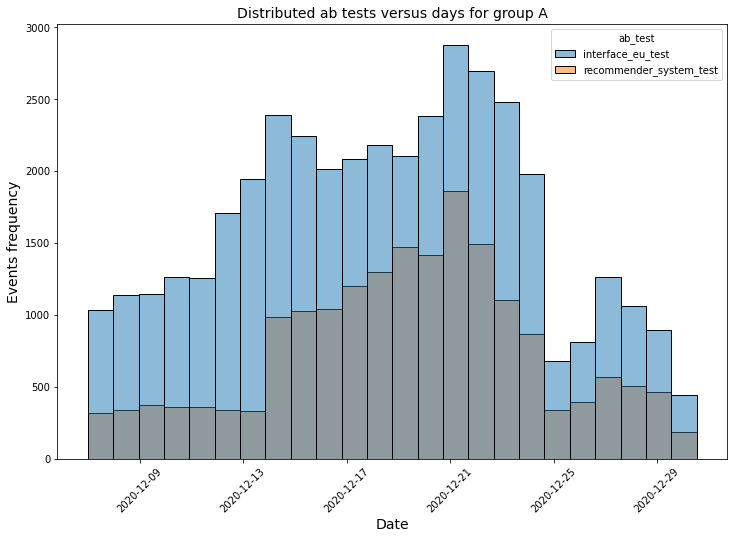

In [587]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
sns.histplot(data = data_A, x = "event_dt", bins = 24, hue = "ab_test")
ax.set_title("Distributed ab tests versus days for group A", fontdict={"size":14})
plt.xlabel("Date", fontdict = {"size":14})
plt.ylabel("Events frequency", fontdict = {"size":14})
plt.xticks(rotation=45)
plt.show()

The graph shows more interface tests conducted than recommender tests in group A.

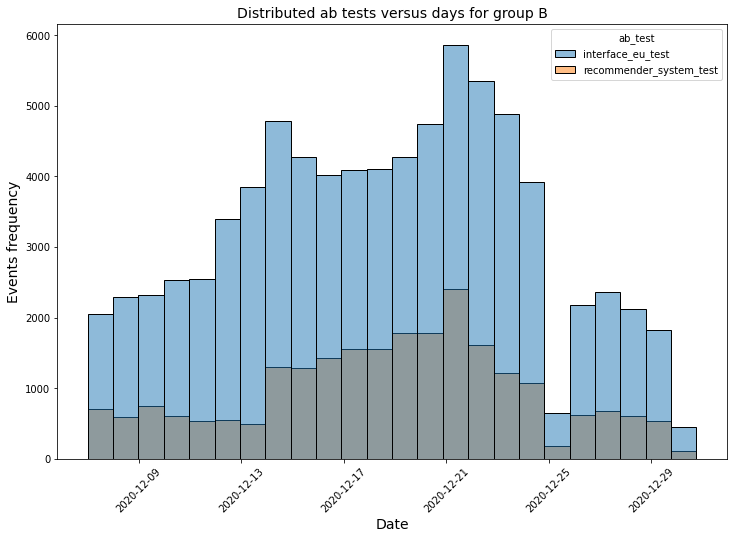

In [588]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
sns.histplot(data = data, x = "event_dt", bins = 24, hue = "ab_test")
ax.set_title("Distributed ab tests versus days for group B", fontdict={"size":14})
plt.xlabel("Date", fontdict = {"size":14})
plt.ylabel("Events frequency", fontdict = {"size":14})
plt.xticks(rotation=45)
plt.show()

The graph shows more interface tests conducted than recommender tests in group B.

**Conclusion**

* There are only 10850 unique users in the interface tests.
* There are only 3481 unique users in the recommender tests.
* Based on the result it is confirmed there are no users in both samples brcause the unique sampless as well as the group samples are the same.
* Based on the result, it can be said the distribution of events and users in Group A and B is very similar.
* Most events happened on 12-21-2020.
* The last new users signing up on 12-21-2020.
* Sign up starts on 12-07-2020.
* The graph looks uniform.

In [589]:
# Merging data frames
users_events = pd.merge(new_users, events, how = 'left', on = 'user_id')

users_events.head()

,user_id,first_date,region,device,event_dt,event_name,details
0,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:10,product_page,0.0
1,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:07,login,0.0
2,F1C668619DFE6E65,2020-12-07,N.America,Android,2020-12-07 16:38:09,product_page,0.0
3,F1C668619DFE6E65,2020-12-07,N.America,Android,2020-12-08 02:02:34,product_page,0.0
4,F1C668619DFE6E65,2020-12-07,N.America,Android,2020-12-23 14:35:41,product_page,0.0


In [590]:
# Joining data frames
users_events_participants = pd.merge(users_events, participants, how= 'left', on= 'user_id')
users_events_participants.tail(5)

,user_id,first_date,region,device,event_dt,event_name,details,group,ab_test
429471,1C7D23927835213F,2020-12-20,EU,iPhone,2020-12-21 04:31:15,login,0.0,B,interface_eu_test
429472,1C7D23927835213F,2020-12-20,EU,iPhone,2020-12-23 15:47:23,login,0.0,B,interface_eu_test
429473,1C7D23927835213F,2020-12-20,EU,iPhone,2020-12-27 03:51:35,login,0.0,B,interface_eu_test
429474,8F04273BB2860229,2020-12-20,EU,Android,2020-12-20 03:17:17,product_cart,0.0,NaN,NaN
429475,8F04273BB2860229,2020-12-20,EU,Android,2020-12-20 03:17:17,login,0.0,NaN,NaN


In [591]:
users_events_participants_recommender = users_events_participants.query('ab_test == "recommender_system_test"')
users_events_participants_recommender.sample(5)

,user_id,first_date,region,device,event_dt,event_name,details,group,ab_test
33850,5A8697B441AAEE78,2020-12-07,EU,PC,2020-12-08 01:04:17,login,0.0,A,recommender_system_test
9226,68F7B81C31BCD5EF,2020-12-07,EU,Mac,2020-12-08 01:05:30,login,0.0,A,recommender_system_test
15646,C9CC41E49C5C4917,2020-12-07,EU,Android,2020-12-07 15:05:27,product_page,0.0,A,recommender_system_test
135329,1A52088F459095E2,2020-12-08,EU,Android,2020-12-11 22:11:09,product_page,0.0,A,recommender_system_test
105008,B4CB05160392ACF1,2020-12-21,EU,iPhone,2020-12-27 11:48:17,product_page,0.0,B,recommender_system_test


In [592]:
# The share of new users from the EU region within the recommender_system_test
new_eu_users = users_events_participants_recommender.query('region == "EU" and first_date <= "2020-12-21"')['user_id'].nunique()

In [593]:
all_users = users_events_participants.query('region == "EU" and first_date <= "2020-12-21"')['user_id'].nunique()


In [594]:
new_eu_users_ratio = new_eu_users / all_users *100
round(new_eu_users_ratio, 2)


8.82

In [595]:
marketing.query('start_dt > "2020-12-21"')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


* The share of new users from the EU region within the recommender_system_test is 8,82.
* There are two days where marketing done after 14 days.

In [596]:
# the reviewer's cell
users_events_participants_recommender.query('(event_dt - first_date) < "14 days"', engine = 'python')

,user_id,first_date,region,device,event_dt,event_name,details,group,ab_test
0,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:10,product_page,0.0,A,recommender_system_test
1,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:07,login,0.0,A,recommender_system_test
141,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-07 15:32:54,product_page,0.0,B,recommender_system_test
143,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-08 08:29:31,product_page,0.0,B,recommender_system_test
145,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-10 18:18:27,product_page,0.0,B,recommender_system_test
...,...,...,...,...,...,...,...,...,...
429341,0416B34D35C8C8B8,2020-12-20,EU,Android,2020-12-21 22:28:29,product_page,0.0,A,recommender_system_test
429342,0416B34D35C8C8B8,2020-12-20,EU,Android,2020-12-24 09:12:51,product_page,0.0,A,recommender_system_test
429343,0416B34D35C8C8B8,2020-12-20,EU,Android,2020-12-20 20:58:25,login,0.0,A,recommender_system_test
429344,0416B34D35C8C8B8,2020-12-20,EU,Android,2020-12-21 22:28:29,login,0.0,A,recommender_system_test


# Step 4. Evaluate the A/B test results¶

**Use the z-criterion to check the statistical difference between the proportions**

In [597]:
data.head(10)

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99,NaT,NaN,NaN,NaN,NaN
1,E1BDDCE0DAFA2679,2020-12-09 06:21:35,purchase,9.99,NaT,NaN,NaN,NaN,NaN
2,E1BDDCE0DAFA2679,2020-12-07 20:22:03,login,0.00,NaT,NaN,NaN,NaN,NaN
3,E1BDDCE0DAFA2679,2020-12-09 06:21:35,login,0.00,NaT,NaN,NaN,NaN,NaN
4,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99,2020-12-07,EU,iPhone,NaN,NaN
5,7B6452F081F49504,2020-12-09 01:50:37,purchase,4.99,2020-12-07,EU,iPhone,NaN,NaN
6,7B6452F081F49504,2020-12-21 08:04:05,purchase,4.99,2020-12-07,EU,iPhone,NaN,NaN
7,7B6452F081F49504,2020-12-22 15:32:04,purchase,9.99,2020-12-07,EU,iPhone,NaN,NaN
8,7B6452F081F49504,2020-12-07 09:22:55,product_page,0.00,2020-12-07,EU,iPhone,NaN,NaN
9,7B6452F081F49504,2020-12-09 01:50:38,product_page,0.00,2020-12-07,EU,iPhone,NaN,NaN


In [598]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 429476 entries, 0 to 429475
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     429476 non-null  object        
 1   event_dt    429476 non-null  datetime64[ns]
 2   event_name  429476 non-null  category      
 3   details     429476 non-null  float64       
 4   first_date  320492 non-null  datetime64[ns]
 5   region      320492 non-null  category      
 6   device      320492 non-null  category      
 7   group       102838 non-null  category      
 8   ab_test     102838 non-null  category      
dtypes: category(5), datetime64[ns](2), float64(1), object(1)
memory usage: 18.4+ MB


In [599]:
data['event_name'].head()

0    purchase
1    purchase
2       login
3       login
4    purchase
Name: event_name, dtype: category
Categories (4, object): ['login', 'product_cart', 'product_page', 'purchase']

In [600]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 429476 entries, 0 to 429475
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     429476 non-null  object        
 1   event_dt    429476 non-null  datetime64[ns]
 2   event_name  429476 non-null  category      
 3   details     429476 non-null  float64       
 4   first_date  320492 non-null  datetime64[ns]
 5   region      320492 non-null  category      
 6   device      320492 non-null  category      
 7   group       102838 non-null  category      
 8   ab_test     102838 non-null  category      
dtypes: category(5), datetime64[ns](2), float64(1), object(1)
memory usage: 18.4+ MB


In [601]:
data.sample(5)

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
46305,26A9947574A5DD45,2020-12-12 00:09:26,product_page,0.0,2020-12-11,EU,Android,A,interface_eu_test
45040,E2CC1F7FA824E7D5,2020-12-22 18:54:18,product_cart,0.0,2020-12-10,EU,PC,NaN,NaN
408293,79717A579D17FD72,2020-12-12 11:10:03,login,0.0,2020-12-11,EU,PC,B,interface_eu_test
227520,FDBF8743431C5EAF,2020-12-16 04:49:07,login,0.0,2020-12-13,EU,PC,NaN,NaN
41374,9AEC3AF9AC12F9FB,2020-12-18 09:21:28,login,0.0,2020-12-10,EU,Android,NaN,NaN


In [602]:
# Create pivot table
data_pivot = data.pivot_table(index='event_name', columns='group', aggfunc=lambda x: x.nunique()).reset_index()

In [603]:
result = data_pivot[['event_name', 'user_id']]

In [604]:
result

event_name user_id      
group                     A     B
0             login    7873  6204
1      product_cart    2483  2037
2      product_page    5208  3986
3          purchase    2682  2008

In [605]:
result.columns = ["event_name", "A", "B"]

**Testing between group A and B**

**Hypothesis**

Significant critical values

alpha value = 1 - (the confidence level / 100)

alpha = 1 - (95/100) = 1 - (0.95)

alpha = 0.05

H0 (Null hypothesis): There are no significant difference between samples A and B for all events.

H1 (Alternative Hypothesis): There are significant difference between samples A and B for all events.

In [606]:
def test_hypothesis(group1,group2, event, alpha=0.05):
    """This function tests the hypothesis that proportions are equal"""
     
    success1 = result[result.event_name == event][group1].iloc[0]
    success2 = result[result.event_name == event][group2].iloc[0]
    
    trials1 = data[data.group == group1]['user_id'].nunique()
    trials2 = data[data.group == group2]['user_id'].nunique()
   
    p1 = success1/trials1
    p2 = success2/trials2

    p_combined = (success1 + success2) / (trials1 + trials2)

    difference = p1 - p2
    
    z_value = difference/mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: {:.3f}'.format(p_value))
    
    if (p_value < alpha):
        print('We reject the H0(null hypothesis): There are significant difference between samples A and B for all events.')
    else:
        print("We can't reject the H0(null hypothesis): There are no significant difference between samples A and B for all events.") 

In [607]:
for i in range(0, len(data_pivot)):
    test_hypothesis('A','B', result['event_name'].unique()[i], alpha=0.05)

p-value: 0.866
We can't reject the H0(null hypothesis): There are no significant difference between samples A and B for all events.
p-value: 0.102
We can't reject the H0(null hypothesis): There are no significant difference between samples A and B for all events.
p-value: 0.019
We reject the H0(null hypothesis): There are significant difference between samples A and B for all events.
p-value: 0.034
We reject the H0(null hypothesis): There are significant difference between samples A and B for all events.


In statistics, the Bonferroni correction is a method to counteract the multiple comparisons problem. 
When performing repeated statistical tests, there is a higher chance of making a type I error, which is why the Bonferroni correction modifies probability (p) results. The correction is perfomed by either taking p-value times n or divide alpha by the number of hypothesis.

In [608]:
bonferroni_alpha = 0.05/4
for event in result['event_name'].unique():
    test_hypothesis('A','B', event, bonferroni_alpha)


p-value: 0.866
We can't reject the H0(null hypothesis): There are no significant difference between samples A and B for all events.
p-value: 0.102
We can't reject the H0(null hypothesis): There are no significant difference between samples A and B for all events.
p-value: 0.019
We can't reject the H0(null hypothesis): There are no significant difference between samples A and B for all events.
p-value: 0.034
We can't reject the H0(null hypothesis): There are no significant difference between samples A and B for all events.


**Testing between group A and B**

**Hypothesis**

Significant critical values

alpha value = 1 - (the confidence level / 100)

alpha = 1 - (99/100) = 1 - (0.99)

alpha = 0.01

H0 (Null hypothesis): There are no significant difference between samples A and B for all events.

H1 (Alternative Hypothesis): There are significant difference between samples A and B for all events.

In [609]:
def test_hypothesis(group1,group2, event, alpha=0.05):
    """This function tests the hypothesis that proportions are equal"""
     
    success1 = result[result.event_name == event][group1].iloc[0]
    success2 = result[result.event_name == event][group2].iloc[0]
    
    trials1 = data[data.group == group1]['user_id'].nunique()
    trials2 = data[data.group == group2]['user_id'].nunique()
   
    p1 = success1/trials1
    p2 = success2/trials2

    p_combined = (success1 + success2) / (trials1 + trials2)

    difference = p1 - p2
    
    z_value = difference/mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))

    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-value: {:.3f}'.format(p_value))
    
    if (p_value < alpha):
        print('We reject the H0(null hypothesis): There are significant difference between samples A and B for all events.')
    else:
        print("We can't reject the H0(null hypothesis): There are no significant difference between samples A and B for all events.") 

In [610]:
for i in range(0, len(data_pivot)):
    test_hypothesis('A','B', result['event_name'].unique()[i], alpha=0.01)

p-value: 0.866
We can't reject the H0(null hypothesis): There are no significant difference between samples A and B for all events.
p-value: 0.102
We can't reject the H0(null hypothesis): There are no significant difference between samples A and B for all events.
p-value: 0.019
We can't reject the H0(null hypothesis): There are no significant difference between samples A and B for all events.
p-value: 0.034
We can't reject the H0(null hypothesis): There are no significant difference between samples A and B for all events.


In [611]:
bonferroni_alpha = 0.01/4
for event in result['event_name'].unique():
    test_hypothesis('A','B', event, bonferroni_alpha)

p-value: 0.866
We can't reject the H0(null hypothesis): There are no significant difference between samples A and B for all events.
p-value: 0.102
We can't reject the H0(null hypothesis): There are no significant difference between samples A and B for all events.
p-value: 0.019
We can't reject the H0(null hypothesis): There are no significant difference between samples A and B for all events.
p-value: 0.034
We can't reject the H0(null hypothesis): There are no significant difference between samples A and B for all events.


When the value of alpha is 0.05, there are significant difference between samples A and B for all events. But, when the value of alpha becomes 0.01, there are no significant difference between samples A and B for all events.
From the result it can be concluded that, sample B is better than sample A, as, there are significant difference between samples A and B in two stage; namely, product cart and purchase. Which means, fail to reject the Null Hypothesis in two stages.

The statistical tests were unable to reject the hypothesis that there was any statistical difference between the A & B groups for purchase page when the value of alpha is 0.05.

In the Bonferroni correction, we fail to reject the Null Hypothesis in all stages. That means there is no significant statistical difference between groups A and B at all stage.

As it is seen from the result even though more users from group 'B' viewed the 'product_cart' and the 'product_page' but more users purchase the products from group 'A' than group 'B', that is users purchased from group 'A' and group 'B' are 1612 and 1479 respectively. It can be concluded group 'A' might have generated more revenue than group 'B'.

# Step 5. Conclusion

   * There are four DataFrames;namely, marketing, new_users, events and participants.
   * The marketing DataFrame has 14 rows and 4 columns. It has all object data types.
   * It has been confirmed that the marketing DataFrames has no duplicates and missing values.
   * Some type types of the marketing DataFrame needs to be converted into the right data type.
   * The new_users DataFrame has 58703 rows and 4 columns. It has all object data types.
   * It has been confirmed that the new_users DataFrames has no duplicates and missing values.
   * Some type types of the new_users DataFrame needs to be converted into the right data type.
   * The events DataFrame has 423761 rows and 4 columns. It has object and float 64 data types.
   * It has been confirmed that the events DataFrames has no duplicates and but it has missing values.
   * The events DataFrame has 363447 missing values in the 'details' column which is more than 85%.
   * Some type types of the events DataFrame needs to be converted into the right data type.
   * The participants DataFrame has 14525 rows and 3 columns. It has all object data type.
   * It has been confirmed that the participants DataFrames has no duplicates and missing values.
   * 58696 users logged in to the website page.
   * 58696 users logged in to the website page.
   * 38929 viewed the products in the website page which is 66.66% from the users who logged in to the website page.
   * 19568 proceed from the product page to the purchase page which is about 33.33% from the logged in users and about 50% from the users who viewed the product page pf the website page.
* The first sign up for new users was 2020-12-07.
* Based on the result the last date registration for the new user was 2020-12-23 not 2020-12-21.
* The first event was 2020-12-07.
* The last event was 2020-12-30.
* The number of new users registered on 2020-12-21 and earlier are 53440.
* The number of new users registered beyond 2020-12-21 are 5263.


* There are only 10850 unique users in the interface tests.
* There are only 3481 unique users in the recommender tests.
* Based on the result it is confirmed there are no users in both samples brcause the unique sampless as well as the group samples are the same.
* Based on the result, it can be said the distribution of events and users in Group A and B is very similar.
* Most events happened on 12-21-2020.
* The last new users signing up on 12-21-2020.
* Sign up starts on 12-07-2020.
* The graph looks uniform.
* The share of new users from the EU region within the recommender_system_test is 8,82.
* There are two days where marketing done after 14 days.
* The percentile of users participated in the project from 'interface_eu_test' and 'recommended_system_test' are 22.96% and 6.42% respectively. Therefor, 'interface_eu_test' is selected for the study as it is greater than 15% while recommended_system_test' from study as it is less than 15%.
* The maximum date is: 2020-12-23 00:00:00.
* The A/B test can be evaluated as the number exceeds 6000 before 2020-12-23 00:00:00.
* There are 34410 users in group A in the merged data.
* There are 33298 users in group B in the merged data.
* It is confirmed there are only participants from EU in the data.

* When the value of alpha is 0.05, there are significant difference between samples A and B for all events. But, when the value of alpha becomes 0.01, there are no significant difference between samples A and B for all events. From the result it can be concluded that, sample B is better than sample A, as, there are significant difference between samples A and B in two stage; namely, product cart and purchase. Which means, fail to reject the Null Hypothesis in two stages.

* The statistical tests were unable to reject the hypothesis that there was any statistical difference between the A & B groups for purchase page when the value of alpha is 0.05.

* In the Bonferroni correction, we fail to reject the Null Hypothesis in all stages. That means there is no significant statistical difference between groups A and B at all stage.


**Recommendation**

The A/B test was conducted almost 3 weeks ahead of Christmas and It was only done for a short period of time, ie, two weeks.Based on this, the results show the tests conducted did not bring any change or difference in the behavior of users, so based on these results, I recommend to stop introduction of an improved recommendation system because it doesn't make sense or should be conducted for some months.